In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

/Users/yanakahitomi/.pyenv/versions/3.5.0/envs/ccg2lambda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# File paths
import glob

EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin'
MODEL_SAVING_DIR = '/Users/yanakahitomi/new/verypluming/ccg2lambda'

In [12]:
# Load training and test set
inputfiles = glob.glob("plain/sick_trial*.txt")
half = int(len(inputfiles)/2)
inputfile_sentences = []
for inputfile in inputfiles:
    filename = re.search("(sick_trial_[0-9]*).", inputfile).group(1)
    f = open(inputfile, "r")
    s = f.readlines()
    f.close()
    g = open("plain2/"+filename+".answer", "r")
    sim = g.readlines()[0]
    g.close()
    inputfile_sentences.append([s[0].strip(), s[1], sim])
df = pd.DataFrame(inputfile_sentences, columns=['sentence1', 'sentence2', 'sim'])
train_df = df[:half]
test_df = df[half:]

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

sentences_cols = ['sentence1', 'sentence2']

# Iterate over the sentences only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both sentences of the row
        for sentence in sentences_cols:

            q2n = []  # q2n -> sentence numbers representation
            for word in text_to_word_list(row[sentence]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace sentence as word to sentence as number representation
            dataset.set_value(index, sentence, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

In [18]:
train_df.shape

(250, 3)

In [16]:
max_seq_length = max(train_df.sentence1.map(lambda x: len(x)).max(),
                     train_df.sentence2.map(lambda x: len(x)).max(),
                     test_df.sentence1.map(lambda x: len(x)).max(),
                     test_df.sentence2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 125
training_size = len(train_df) - validation_size

X = train_df[sentences_cols]
Y = train_df['sim']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.sentence1, 'right': X_train.sentence2}
X_validation = {'left': X_validation.sentence1, 'right': X_validation.sentence2}
X_test = {'left': test_df.sentence1, 'right': test_df.sentence2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [19]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/yanakahitomi/.pyenv/versions/3.5.0/envs/ccg2lambda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/yanakahitomi/.pyenv/versions/3.5.0/envs/ccg2lambda/lib/python3.5/site-packages/ipykernel/__main__.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 125 samples, validate on 125 samples
Epoch 1/25
125/125 [==============================] - 1s - loss: 12.3848 - acc: 0.0000e+00 - val_loss: 12.3123 - val_acc: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 0s - loss: 12.2752 - acc: 0.0000e+00 - val_loss: 12.2432 - val_acc: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 0s - loss: 12.1757 - acc: 0.0000e+00 - val_loss: 12.1788 - val_acc: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 0s - loss: 12.0783 - acc: 0.0000e+00 - val_loss: 12.1169 - val_acc: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 0s - loss: 11.9808 - acc: 0.0000e+00 - val_loss: 12.0558 - val_acc: 0.0000e+00
Epoch 6/25
125/125 [==============================] - 

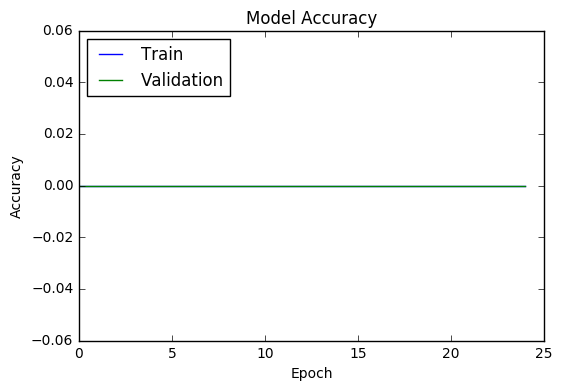

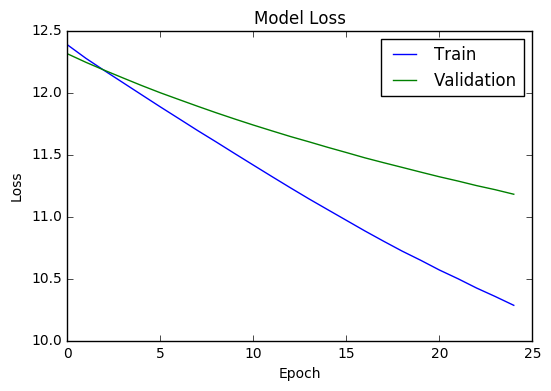

In [20]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()